# Step A - Multiple Product Detection

- Baraghini Nicholas
- Marini Luca

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
sift = cv2.xfeatures2d.SIFT_create()

In [3]:
def Matching(Model_Descriptors, Scene_Descriptors, Treshold = 0.45, k=2):
    FLANN_INDEX_KDTREE = 1

        # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

        # Defining search params.
        # checks=50 specifies the number of times the trees in the index should be recursively traversed.
        # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

        # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
        # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(Model_Descriptors, Scene_Descriptors, k)
        #defining an array containing all the matches that results to be considered "good" matches applying a certain treshold 
    good = []
    for m,n in matches:
        if m.distance < Treshold * n.distance: #  if m.distance/n.distance < Threshold:
            good.append(m)
            
    return good

In [4]:
def print_result(e_results, idx_of_scene):
    for i in models_to_test:
        print('Product {} - {} instance/s found:'.format(i, e_results[idx_of_scene][i]['count']))
        n = 0
        if e_results[idx_of_scene][i].get('width', None):
            n += 1
            print('\tInstance {} position: {}, width: {}px, height: {}px'.format(n, e_results[idx_of_scene][i]['pos'], e_results[idx_of_scene][i]['width'], e_results[idx_of_scene][i]['height']))
    print('_' * 80 + '\n')

In [5]:
def distance_2_points(A, B):
    return math.sqrt( np.power(A[0] - B[0], 2) +  np.power(A[1] - B[1], 2))

In [6]:
# function that plots the final merged bounding boxes
def plot_final_bounding_boxes(img, final_corners_of_bounding_boxes, difficulty_scenes_images_features, j, thickness=20):
    #print('Final corners of bounding boxes:')
    #print(final_corners_of_bounding_boxes)
    
    if img is None:
        img = np.copy(difficulty_scenes_images_features[j][IMAGE_INDEX])
    #print(img.shape)

    
    # print final bounding boxes on an image
    for top_left_corner, bottom_right_corner in final_corners_of_bounding_boxes:
        scene_img_with_FINAL_bounding_boxes = cv2.rectangle(img, top_left_corner, bottom_right_corner, (0,255,0), thickness)

    
    
    # plot image with final bounding boxes (with bounding boxes that do not overlap each other)
    if(len(final_corners_of_bounding_boxes) > 0):
        #print('  - Found {} instances of model {} in scene {}'.format(len(final_corners_of_bounding_boxes),i,j))
        # plotting the bounding box
        #plt.imshow(cv2.cvtColor(scene_img_with_FINAL_bounding_boxes, cv2.COLOR_BGR2RGB))
        #plt.show()
        
        return scene_img_with_FINAL_bounding_boxes
    else:
        #print('  - Model {} NOT found in the scene {}'.format(i,j))
        return None

In [7]:
# function that solves exceeding dimensions of bounding_boxes in scene
def solve_exceeding_dimensions_of_bounding_boxes_in_scene(final_corners_of_bounding_boxes, difficulty_scenes_images_features):
    final_corners_of_bounding_boxes_without_exceeding_dimensions = []
    # adjust bounding boxes that go out the dimensions of the scene image
    scene_height = difficulty_scenes_images_features[j][IMAGE_INDEX].shape[0]
    scene_width = difficulty_scenes_images_features[j][IMAGE_INDEX].shape[1]

    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes):
        fin_top_left_corner = list(fin_top_left_corner)
        fin_bottom_right_corner = list(fin_bottom_right_corner)
        # top left corner that goes out on the left of the scene image
        if fin_top_left_corner[0] < 0:
            fin_top_left_corner[0] = 0
        # bottom right corner that goes out on the left of the scene image
        if fin_bottom_right_corner[0] < 0:
            fin_bottom_right_corner[0] = 0
        # top left corner that goes out on the right of the scene image
        if fin_top_left_corner[0] > scene_width:
            fin_top_left_corner[0] = scene_width
        # bottom right corner that goes out on the right of the scene image
        if fin_bottom_right_corner[0] > scene_width:
            fin_bottom_right_corner[0] = scene_width
        # top left corner that goes out on the top of the scene image
        if fin_top_left_corner[1] < 0:
            fin_top_left_corner[1] = 0
        # bottom right corner that goes out on the top of the scene image
        if fin_bottom_right_corner[1] < 0:
            fin_bottom_right_corner[1] = 0  
        # top left corner that goes out on the bottom of the scene image
        if fin_top_left_corner[1] > scene_height:
            fin_top_left_corner[1] = scene_height
        # bottom right corner that goes out on the bottom of the scene image
        if fin_bottom_right_corner[1] > scene_height:
            fin_bottom_right_corner[1] = scene_height

        fin_top_left_corner = tuple(fin_top_left_corner)
        fin_bottom_right_corner = tuple(fin_bottom_right_corner)
        final_corners_of_bounding_boxes_without_exceeding_dimensions.append([ (int(fin_top_left_corner[0]), 
                                                                               int(fin_top_left_corner[1])), 
                                                                             (int(fin_bottom_right_corner[0]), 
                                                                              int(fin_bottom_right_corner[1]))])
    return final_corners_of_bounding_boxes_without_exceeding_dimensions

In [8]:
# function that split an image into (n_bins_heigth x n_bins_width) bins and returns a dictonary
# that contains the means of the 3 color channels of the (n_bins_heigth x n_bins_width) bins
def split_image_into_N_x_M_bins_with_intensity_means(image, n_bins_width = 3, n_bins_heigth = 4):
    img_N_x_M_bins = {}
    
    img2 = np.copy(image)
    
    img_width = image.shape[1]
    img_height = image.shape[0]
    
    step_width = int(img_width / n_bins_width)
    step_height = int(img_height / n_bins_heigth)
    
    r = 0
    c = 0
    
    #print('img_height: ', img_height)
    #print('step_height: ', step_height)
    if img_height != 0 and step_height != 0 and img_width != 0 and step_width != 0:
        for row in np.arange(0, img_height, step_height):
            c = 0
            cv2.line(img2,(0, row),(img_width, row),(0,0,0),3) 
            for col in np.arange(0, img_width, step_width):
                # print('row {} col {}'.format(r,c))
                if row + 2 * step_height > img_height and col + 2 * step_width > img_width:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row:, col:])

                elif row + 2 * step_height > img_height:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row:, col : col + step_width])

                elif col + 2 * step_width > img_width:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row : row + step_height, col :])
                else:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(
                        image[row : row + step_height, col : col + step_width])

                cv2.line(img2,(col, 0),(col, img_height),(0,0,0),3) 
                if r < n_bins_heigth and c < n_bins_width:
                    # save means of the 3 channels (r,g,b) of each bin
                    img_N_x_M_bins[r, c] = (np.mean(partial_r_channel), np.mean(partial_g_channel), np.mean(partial_b_channel))
                    # IF YOU WANT TO VISUALIZE EACH BIN UNCOMMENT THE FOLLOWING LINES:
                    # plot each bin in blue channel color
                    # plt.imshow(cv2.cvtColor(partial_b_channel, cv2.COLOR_BGR2RGB))
                    # plt.show()

                    # salva le medie e non le immagini dei bins

                c += 1
            r += 1
        #plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        #plt.show()  
    return img_N_x_M_bins
        

In [9]:
def solve_color_problem_with_N_x_M_bins(final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                    difficulty_scenes_images_features, i, j, N=3, M=4, 
                                    COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=50, MAX_NUM_OF_NO_GOOD_CELLS=2):
    final_corners_of_bounding_boxes_after_color_problem = []
    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes_without_exceeding_dimensions):
    
        means_bins_model_img = split_image_into_N_x_M_bins_with_intensity_means(
            model_images_features[i][IMAGE_INDEX], 
            N, M)
        
        #print(fin_top_left_corner[1], fin_top_left_corner[0], fin_bottom_right_corner[1], fin_bottom_right_corner[0])
        
        means_bins_scene_img = split_image_into_N_x_M_bins_with_intensity_means(
            difficulty_scenes_images_features[j][IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                   fin_top_left_corner[0]:fin_bottom_right_corner[0]], 
            N, M)
    
        if not means_bins_scene_img or not means_bins_scene_img:
            return []
    
        good = True
        num_of_No_good = 0
        
        
        # cycle the model dictionary and get the diff of the means by getting the keys of the scene dictionary
        for k, v in means_bins_model_img.items():
            means_k_scene = means_bins_scene_img.get(k)
            # I consider a bounding box as good if and only if all the difference of the intiensities from the 
            # bins of the model, in all 3 channels, are below a certain treshold
            diff_r = np.absolute(v[0] - means_k_scene[0])
            diff_g = np.absolute(v[1] - means_k_scene[1])
            diff_b = np.absolute(v[2] - means_k_scene[2])
            
            #print('Bin ({}, {}):'.format(k[0], k[1]))
            #print('  - diff_r: ', diff_r)
            #print('  - diff_g: ', diff_g)
            #print('  - diff_b: ', diff_b)
            
            # PRINT ALL THE DIFFERENCES
            # print('diff_r: ', diff_r)
            # print('diff_g: ', diff_g)
            # print('diff_b: ', diff_b)

            
            if diff_r >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or diff_g >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or \
                diff_b >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES:
                #print('___________________NO GOOD___________________')
                num_of_No_good += 1
                good = False
            
        if num_of_No_good < MAX_NUM_OF_NO_GOOD_CELLS:
            final_corners_of_bounding_boxes_after_color_problem.append([ (int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                                                        (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))])
            
    
    return final_corners_of_bounding_boxes_after_color_problem

In [10]:
NUM_OF_MODELS = 27

IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2
CENTER_INDEX     = 3
V_INDEX          = 4
TRESHOLD_INDEX = 5

# Dictionary that contains the image, all keypoints and descriptors for each model images
model_images_features = {}
mean_of_model_intensities_r_g_b = {}

for i in range(NUM_OF_MODELS):
    model_img = cv2.imread('./models/{}.jpg'.format(i), cv2.COLOR_BGR2RGB)
    kp_model = sift.detect(model_img)
    kp_model, des_model = sift.compute(model_img, kp_model)
    model_images_features[i] = [model_img, kp_model, des_model]
    
    b,g,r = cv2.split(model_images_features[i][IMAGE_INDEX])
    # save the mean of the intensities (divided per channel) for every model image
    mean_of_model_intensities_r_g_b[i] = [np.mean(r), np.mean(g), np.mean(b)]
    # print(mean_of_model_intensities_r_g_b[i][0], mean_of_model_intensities_r_g_b[i][1], mean_of_model_intensities_r_g_b[i][2])
    # print(model_images_features[i][IMAGE_INDEX][0].shape)
    # print(mean_of_model_intensities[i])

    
    # plt.imshow(cv2.cvtColor(model_images_features[str(i)][0], cv2.COLOR_BGR2RGB))
    # plt.show()

In [11]:
# function that plots the final merged bounding boxes
def plot_dark_area_bounding_boxes(img, final_corners_of_bounding_boxes, difficulty_scenes_images_features, j):
    #print('Final corners of bounding boxes:')
    #print(final_corners_of_bounding_boxes)

    # print final bounding boxes on an image
    for top_left_corner, bottom_right_corner in final_corners_of_bounding_boxes:
        scene_img_with_FINAL_bounding_boxes = cv2.rectangle(img, top_left_corner, bottom_right_corner, (0,0,0), -1)
    
    # plot image with final bounding boxes (with bounding boxes that do not overlap each other)
    if(len(final_corners_of_bounding_boxes) > 0):
        #print('  - Found {} instances of model {} in scene {}'.format(len(final_corners_of_bounding_boxes),i,j))
        # plotting the bounding box
        #plt.imshow(cv2.cvtColor(scene_img_with_FINAL_bounding_boxes, cv2.COLOR_BGR2RGB))
        #plt.show()
        
        return scene_img_with_FINAL_bounding_boxes
    else:
        #print('  - Model {} NOT found in the scene {}'.format(i,j))
        return None

In [12]:
scenes_to_test = [1, 2, 3, 4, 5]

# Dictionary that contains the image, all keypoints and descriptors for each easy scene image
e_scenes_images_features = {}

for i in scenes_to_test:
    scene_img = cv2.imread('./scenes/e{}.png'.format(i), cv2.COLOR_BGR2RGB)
    kp_scene = sift.detect(scene_img)
    kp_scene, des_scene = sift.compute(scene_img, kp_scene)
    e_scenes_images_features[i] = [scene_img, kp_scene, des_scene]
    # scene_img_visualization = cv2.drawKeypoints(scene_img,kp_e_scemes_images['1'],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # plt.imshow(cv2.cvtColor(e_scenes_images_features[str(i)][0], cv2.COLOR_BGR2RGB))
    # plt.show()

In [13]:
# dictionary that will contain the output to be printed
e_results = {}    

In [14]:
IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2

models_to_test = [0,1,11, 19, 24, 26, 25] #[1] #, 1, 11, 19, 24, 26, 25] # [0,11,25]
scenes_to_test = [1,2,3,4,5] # [2,3,4]
MATCHING_TRESHOLD = 0.45

MIN_NUM_OF_MATCHES = 15

COLOR_DIFF_IN_SINGLE_CHANNEL_TRES = 79

N_BINS_ON_WIDTH = 3

M_BINS_ON_HEIGHT = 4

final_scene_images_with_bb = {}

scene_single_model_features = {}

MAX_NUM_OF_NO_GOOD_CELLS = 1

for j in scenes_to_test:
    final_scene_images_with_bb[j] = np.copy(e_scenes_images_features[j][IMAGE_INDEX])
    e_results[j] = {}
    for i in models_to_test:
        scene_single_model = np.copy(e_scenes_images_features[j][IMAGE_INDEX])
        #print('_' * 80 + '\n')
        #print('Finding model {} in scene {}'.format(i,j))
        
        e_results[j][i] = {}
        e_results[j][i]['count'] = 0
        
        # Checking if we found enough matching
        MIN_MATCH_COUNT = MIN_NUM_OF_MATCHES
        
        finding = True
        
        # If enough matches => the model is in the scene image
        while finding:
            
            kp_scene = sift.detect(scene_single_model)
            kp_scene, des_scene = sift.compute(scene_single_model, kp_scene)
            scene_single_model_features[j] = [scene_single_model, kp_scene, des_scene]
            good = Matching(model_images_features[i][DESCRIPTOR_INDEX], scene_single_model_features[j][DESCRIPTOR_INDEX], 
                            Treshold = MATCHING_TRESHOLD, k=2)#flann.knnMatch(model_images_features[i][DESCRIPTOR_INDEX], e_scenes_images_features[j][DESCRIPTOR_INDEX], k=2)
            good = Matching(model_images_features[i][DESCRIPTOR_INDEX], scene_single_model_features[j][DESCRIPTOR_INDEX], 
                            Treshold = MATCHING_TRESHOLD, k=2)#flann.knnMatch(model_images_features[i][DESCRIPTOR_INDEX], e_scenes_images_features[j][DESCRIPTOR_INDEX], k=2)
 
            #print(len(good))
            
            if len(good) < MIN_MATCH_COUNT:
                finding = False
                
            if len(good) >= MIN_MATCH_COUNT:
                
                # building the corrspondences arrays of good matches
                src_pts = np.float32([ model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
                dst_pts = np.float32([ scene_single_model_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)

                # Using RANSAC to estimate a robust homography. 
                # It returns the homography M and a mask for the discarded points
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

                # Mask of discarded point used in visualization
                matchesMask = mask.ravel().tolist()

                # Corners of the query image
                h,w = model_images_features[i][IMAGE_INDEX].shape[:2]
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) # myc: these are the 4 corners of the query image

                # Projecting the corners into the train image
                dst = cv2.perspectiveTransform(pts,M) # myc: you project the corners by using the homography. M is the homography          

                # Drawing the bounding box
                #scene_img = cv2.polylines(e_scenes_images_features[j][IMAGE_INDEX], [np.int32(dst)],
                                          #True, (0, 255, 0), 3, cv2.LINE_AA)
                #e_results[j][i]['pos']
                top_left_bound_box_corner = dst[0][0]
                bottom_left_bound_box_corner = dst[1][0]
                top_right_bound_box_corner = dst[3][0]
                bottom_right_bound_box_corner = dst[2][0]
                # print(top_left_bound_box_corner)

                # compute width and height of the current bounding box
                width_of_bounding_box = int(distance_2_points(top_left_bound_box_corner, top_right_bound_box_corner))
                height_of_bounding_box = int(distance_2_points(top_left_bound_box_corner, bottom_left_bound_box_corner))

                # I consider the current bounding box as good only if it has a shape of a rectangle, 
                # with an height > of the width, as the cereal boxes
                if width_of_bounding_box < height_of_bounding_box:

                    final_corners_of_bounding_boxes = []
                    final_corners_of_bounding_boxes.append([top_left_bound_box_corner, bottom_right_bound_box_corner])
                    final_corners_of_bounding_boxes_without_exceeding_dimensions = solve_exceeding_dimensions_of_bounding_boxes_in_scene(final_corners_of_bounding_boxes, e_scenes_images_features)


                    # solve color problem with bins

                    final_corners_of_bounding_boxes_after_color_problem = solve_color_problem_with_N_x_M_bins(
                        final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                        e_scenes_images_features, i, j, N=N_BINS_ON_WIDTH, M=M_BINS_ON_HEIGHT, 
                        COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=COLOR_DIFF_IN_SINGLE_CHANNEL_TRES,
                        MAX_NUM_OF_NO_GOOD_CELLS=MAX_NUM_OF_NO_GOOD_CELLS)

                    # solve color problem without bins (as an unique image)
                    #final_corners_of_bounding_boxes_after_color_problem = solve_color_problem(
                    #    final_corners_of_bounding_boxes_without_exceeding_dimensions, e_scenes_images_features, j)

                    if len(final_corners_of_bounding_boxes_after_color_problem) > 0:
                        finding = False
                        for [fin_top_left_corner, fin_bottom_right_corner] in final_corners_of_bounding_boxes_after_color_problem:
                            e_results[j][i]['count'] += 1

                            # Save width and height measures of the bounding box
                            e_results[j][i]['width'] = width_of_bounding_box
                            e_results[j][i]['height'] = height_of_bounding_box

                            # Save the position of the bounding box
                            e_results[j][i]['pos'] = (int(fin_top_left_corner[0]), int(fin_top_left_corner[1]))

                    else:
                        #print('NO CORNERS AFTER COLOR CORRECTION')
                        for [fin_top_left_corner, fin_bottom_right_corner] in final_corners_of_bounding_boxes_without_exceeding_dimensions:
                            scene_single_model = plot_dark_area_bounding_boxes(scene_single_model, 
                                                                               final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                                                               e_scenes_images_features, j)
                        #plt.imshow(cv2.cvtColor(scene_single_model, cv2.COLOR_BGR2RGB))
                        #plt.show()

                    #print('COLOR CORRECTION DONE:')
                    img_bb = plot_final_bounding_boxes(final_scene_images_with_bb[j], final_corners_of_bounding_boxes_after_color_problem, 
                                              e_scenes_images_features, j)
                    if img_bb is not None:
                        final_scene_images_with_bb[j] = img_bb

            else:
                #print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
                matchesMask = None

            # Drawing the matches
            draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                               singlePointColor = None, # not draw keypoints only matching lines
                               matchesMask = matchesMask, # draw only inliers
                               flags = 2) # not draw keypoints only lines
            img3 = cv2.drawMatches(model_images_features[i][IMAGE_INDEX], 
                                   model_images_features[i][KEYPOINT_INDEX], 
                                   e_scenes_images_features[j][IMAGE_INDEX], 
                                   e_scenes_images_features[j][KEYPOINT_INDEX],
                                   good, 
                                   None,  
                                   **draw_params)
            #plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
            #plt.show()

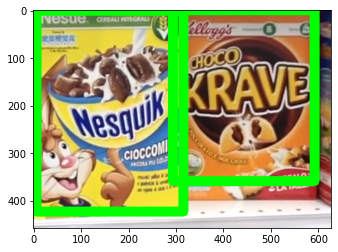

Product 0 - 1 instance/s found:
	Instance 1 position: (7, 1), width: 311px, height: 437px
Product 1 - 0 instance/s found:
Product 11 - 1 instance/s found:
	Instance 1 position: (294, 0), width: 300px, height: 391px
Product 19 - 0 instance/s found:
Product 24 - 0 instance/s found:
Product 26 - 0 instance/s found:
Product 25 - 0 instance/s found:
________________________________________________________________________________



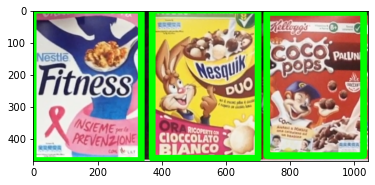

Product 0 - 0 instance/s found:
Product 1 - 0 instance/s found:
Product 11 - 0 instance/s found:
Product 19 - 0 instance/s found:
Product 24 - 1 instance/s found:
	Instance 1 position: (0, 0), width: 334px, height: 490px
Product 26 - 1 instance/s found:
	Instance 1 position: (371, 0), width: 337px, height: 490px
Product 25 - 1 instance/s found:
	Instance 1 position: (728, 7), width: 309px, height: 446px
________________________________________________________________________________



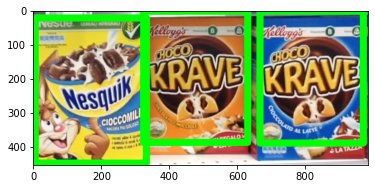

Product 0 - 1 instance/s found:
	Instance 1 position: (6, 20), width: 325px, height: 444px
Product 1 - 1 instance/s found:
	Instance 1 position: (667, 0), width: 301px, height: 412px
Product 11 - 1 instance/s found:
	Instance 1 position: (325, 0), width: 297px, height: 396px
Product 19 - 0 instance/s found:
Product 24 - 0 instance/s found:
Product 26 - 0 instance/s found:
Product 25 - 0 instance/s found:
________________________________________________________________________________



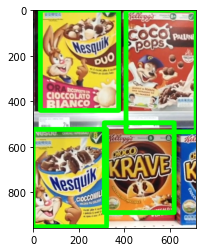

Product 0 - 1 instance/s found:
	Instance 1 position: (0, 523), width: 325px, height: 444px
Product 1 - 0 instance/s found:
Product 11 - 1 instance/s found:
	Instance 1 position: (312, 494), width: 298px, height: 398px
Product 19 - 0 instance/s found:
Product 24 - 0 instance/s found:
Product 26 - 1 instance/s found:
	Instance 1 position: (32, 0), width: 344px, height: 497px
Product 25 - 1 instance/s found:
	Instance 1 position: (407, 0), width: 298px, height: 577px
________________________________________________________________________________



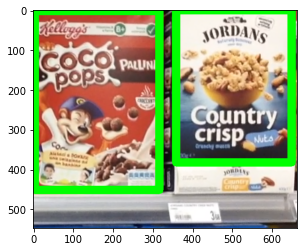

Product 0 - 0 instance/s found:
Product 1 - 0 instance/s found:
Product 11 - 0 instance/s found:
Product 19 - 1 instance/s found:
	Instance 1 position: (359, 0), width: 293px, height: 387px
Product 24 - 0 instance/s found:
Product 26 - 0 instance/s found:
Product 25 - 1 instance/s found:
	Instance 1 position: (4, 2), width: 319px, height: 445px
________________________________________________________________________________



In [15]:
for j in scenes_to_test:
    plt.imshow(cv2.cvtColor(final_scene_images_with_bb[j], cv2.COLOR_BGR2RGB))
    plt.show()
    print_result(e_results, j)